In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

# Time-dependent Heat or Diffusion Equation

As an extension of the Poisson equation, we consider the time-dependent heat equation, or the time-dependent diffusion equation. This is a natural extension of the Poisson equation describing the stationary distribution of heat in a body to a time-dependent problem.

## PDE problem ##

Our model problem for time-dependent PDEs reads


\begin{alignat}{2}
{\partial u\over\partial t} &= \Delta u + f \quad &&\hbox{in }\Omega\times(0, T], \tag{1}\\
u &= u_D &&\hbox{on } \partial \Omega\times(0, T],\tag{2}\\
u &= u_0 &&\mbox{at } t=0. \tag{3}
\end{alignat}

Here, $u({\bf x},t)$ is space-time-dependent function. The source function $f$ and the
boundary values $u_D$ may also vary with space and time. $T$ is the final time. The initial condition $u_0$ is a function of space only.

## Variational formulation ##

A straightforward approach to solving time-dependent PDEs by the
finite element method is to first discretize the time derivative by a
finite difference approximation, which yields a sequence of
stationary problems, and then turn each stationary problem into a
variational formulation.

### Time-discretization of the heat equation

Let superscript $(n)$ denote a quantity at time $t_n$, where $n$ is an integer counting time levels. For example, $u^{(n)}$ means $u(t_n)$ at time level $n$.

A finite difference discretization in time first consists of sampling the PDE at some time level, say $t_{n+1}$:

\begin{equation}
\left({\partial u \over\partial t}\right)^{(n+1)} = \Delta u^{(n+1)} + f^{(n+1)}.  \tag{4}
\end{equation}

The time-derivative can be approximated by a difference quotient.
For simplicity and stability reasons, we choose a
simple **backward Euler method** (or **implicit Euler method**):

\begin{equation}
\left({\partial u\over\partial t}\right)^{(n+1)}\approx {{u^{(n+1)} - u^{(n)}}\over{\Delta t}}, \tag{5}
\end{equation}
where $\Delta t = t_{n+1} - t_n$ is the time discretization parameter. Inserting (5) in (1) yields:

**Semi-discretization of the heat equation:**

\begin{equation}
{{u^{(n+1)} - u^{(n)}}\over{\Delta t}} = \Delta u^{(n+1)} + f^{(n+1)}. \tag{6}
\end{equation}

This is our time-discrete version of the heat equation (1), a so-called **backward Euler** or **implicit Euler** discretization.

We may reorder (6) so that the left-hand side contains the terms with the unknown $u^{(n+1)}$ and
the right-hand side contains computed terms only. The result is a sequence of spatial (stationary) problems for $u^{(n+1)}$, assuming $u^{(n)}$ is known from the previous time step:

\begin{align}
u^{(0)} &= u_0,\tag{7a}\\
u^{(n+1)} - {\Delta t}\Delta u^{(n+1)} &=  u^{(n)} + {\Delta t} f^{(n+1)},\quad n = 0,1,2,\ldots  \tag{7b}
\end{align}

#### **Algorithm**

Start with $u_0$ and choose a timestep $\Delta t > 0$.

- For n = 0, 1, . . ., solve for $u^{(n+1)}$

\begin{equation}
u^{(n+1)} - {\Delta t}\Delta u^{(n+1)} =  u^{(n)} + {\Delta t} f^{(n+1)}. \tag{8}
\end{equation}

At each time step, we use a finite element method to solve (8). This requires turning the equations into weak forms.  As usual, we multiply by a test function $v \in V_0 = \left\{ u \in H^1(\Omega)  | u = 0 \text{ on } \partial \Omega \right\}$:

$$
\int_\Omega u^{(n+1)}v dx  - {\Delta t} \int_\Omega \Delta u^{(n+1)} v dx  =  \int_\Omega u^{(n)} v dx  + {\Delta t} \int_\Omega f^{(n+1)} v dx,
$$

and integrate second-derivatives by parts:

$$
 \int_\Omega u^{(n+1)}v dx + {\Delta t} \bigg(\int_\Omega \nabla u^{(n+1)}\cdot \nabla v dx -
\int_{\partial\Omega}\frac{\partial u^{(n+1)}}{\partial n}v ds \bigg) = \int_\Omega u^{(n)} v dx  + {\Delta t} \int_\Omega f^{(n+1)} v dx,
$$

Inserting the boundary conditions, we obtain:

$$
 \int_\Omega u^{(n+1)}v dx + {\Delta t} \int_\Omega \nabla u^{(n+1)}\cdot \nabla v dx  = \int_\Omega u^{(n)} v dx  + {\Delta t} \int_\Omega f^{(n+1)} v dx.
$$

The resulting weak form arising from formulation (8) can be written in the standard notation:

\begin{equation}
\text{ Find } \quad u = u^{(n+1)} \in   V_{u_D} = \left\{ u \in H^1(\Omega)  | u = u_D \text{ on } \partial \Omega \right\} \text{ such that: }\\
a(u,v)=L_{n+1}(v), \forall v \in V_0,
\end{equation}
where

\begin{align}
a(u,v) &= \int_\Omega\left(uv + {\Delta t}
\boldsymbol{\nabla} u\cdot \boldsymbol{\nabla} v\right) \mbox{d}x,\\
L_{n+1}(v) &= \int_\Omega \left(u^{(n)} + {\Delta t}  f^{(n+1)}\right)v \mbox{d}x.
\end{align}

**The initialization step:**

In addition to the variational problem to be solved in each time step, we also need to approximate the initial condition (7a). This equation can also be turned into a variational problem:

$$ a_0(u,v)=L_0(v),$$

with

\begin{align}
a_0(u,v) &= \int_\Omega uv \mbox{d}x,\\
L_0(v) &= \int_\Omega u_0 v \mbox{d}x.
\end{align}

## FEniCS implementation ##

We now, solve this problem using FEniCS as follows:

### Concrete example:

We choose a simple 2D domain: the unit square $\Omega = [0,1] \times [0,1]$ .

In order to compare the finite element solution to the exact solution, here we construct a model problem with the exact solution:

\begin{equation} u_{ex}(x,y,t) =1 + x^2 + \alpha y^2 + \beta t,. \end{equation}

If we substitute this exact solution ${u_{ex}}$ into heat equation we find that $f$ is:

\begin{equation} f(x,y,t) = \beta - 2 - 2\alpha. \end{equation}

The boundary condition is :

\begin{equation}{u_D}(x,y) = 1 + x^2 + \alpha y^2 + \beta t, \end{equation}

and the initial value is obtained at $t = 0$:
$$u_0(x, y) = 1 + x^2 + \alpha y^2.$$

### FEniCS implementation ###

In [ ]:
from dolfin import *
import numpy as np
from mshr import *
import matplotlib.pyplot as plt
%matplotlib inline

### We first create a mesh and define the finite element space:

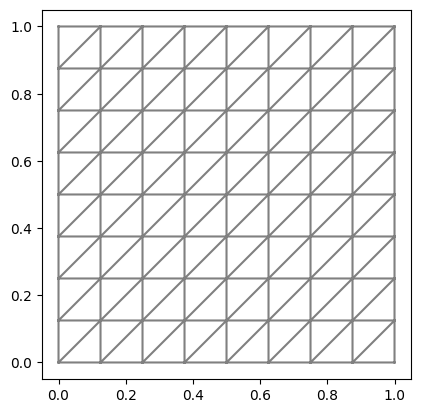

In [ ]:
# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
plot(mesh)

# Define the finite element space
V = FunctionSpace(mesh, 'P', 1)

### Setting problem parameters

We use a FEniCS `Expression` with time $t$, $\alpha$ and $\beta$ as a parameters.

In [ ]:
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size

alpha = 3; beta = 1.2
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

f = Constant(beta - 2 - 2*alpha)

This `Expression` uses the components of `x` as independent
variables, while `alpha`, `beta`, and `t` are parameters. The
time `t` can later be updated by

```
u_D.t = t
```

### Defining boundary conditions

In [ ]:
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

We shall use the variable `u` for the unknown $u^{(k+1)}$ at the new
time step and the variable `u_k` for $u^{(k)}$ at the previous time
step. The initial value of `u_k` can be computed by either projection
or interpolation of $u_0$. Since we set `t = 0` for the boundary value
`u_D`, we can use `u_D` to specify the initial condition $u_0$:

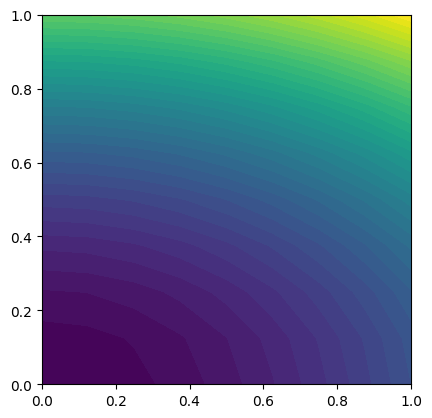

In [ ]:
# Compute and Plot the initial solution
u_k = interpolate(u_D, V)

plot(u_k)

## Defining the variational problem

In [ ]:
u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + dt*dot(grad(u), grad(v))*dx

L =  (u_k + dt*f)*v*dx

### Finally, we perform the time-stepping in a loop:

t = 0.20: error = 0.688
t = 0.40: error = 0.149
t = 0.60: error = 0.0298
t = 0.80: error = 0.00588
t = 1.00: error = 0.00115
t = 1.20: error = 0.000226
t = 1.40: error = 4.44e-05
t = 1.60: error = 8.7e-06
t = 1.80: error = 1.71e-06
t = 2.00: error = 3.34e-07


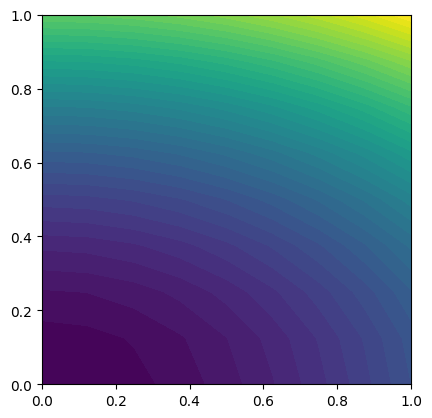

In [ ]:
u = Function(V)
t = 0

for k in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Solve variational problem
    solve(a == L, u, bc)

    # Compute maximum error at vertices

    vertex_values_u_D = u_D.compute_vertex_values(mesh)
    vertex_values_u = u.compute_vertex_values(mesh)
    error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
    print('t = %.2f: error = %.3g' % (t, error_max))

    # Update previous solution

    u_k.assign(u)

plot(u_k)

In the last step of the time-stepping loop, we assign the values of the variable `u` (the new computed solution) to the variable `u_k` containing the values at the previous time step.

Inside the time loop, we use  `u_D.t` to updated before the `solve` statement to enforce computation of Dirichlet conditions at the current time step.

##Excercise:

In [ ]:
from dolfin import *
import numpy as np
from mshr import *
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
domain = Rectangle(Point(-3.,-3.), Point(3.,3.)) - Circle(Point(0.,0.),1)

mesh = generate_mesh ( domain, 10 )

plot ( mesh, title = 'heat Mesh' )

In [ ]:
#  Define the function space.
#
V = FunctionSpace ( mesh, "Lagrange", 1 )
#
#  Define the boundary conditions.
#
Tol = DOLFIN_EPS
u_D1 = 300.0

class ext(SubDomain):
    def inside(self, x, on_boundary):
      return ( on_boundary and ( (abs( x[0]-3.0 ) < Tol) or
                                 (abs( x[0]+3.0 ) < Tol) or
                                 (abs( x[1]-3.0 ) < Tol) or
                                 (abs( x[1]+3.0 ) < Tol) ) )

Ext = ext()

# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

boundaries.set_all(0)

Ext.mark(boundaries, 1)

u_D2 = 400.0

ds=Measure('ds', domain=mesh, subdomain_data=boundaries)

def inter ( x, on_boundary ):
    r = sqrt ( ( x[0] ) ** 2 + ( x[1] ) ** 2 )
    return ( on_boundary and ( r < 1 * 1.1 ) )

bc2 = DirichletBC ( V, u_D2, inter )
#
bc = [bc2 ]
#

In [ ]:
#  The trial functions (u) and test functions (v).
#
u = TrialFunction ( V )
v = TestFunction ( V )
#
#  Define the bilinear form.
#
a = inner ( u, v ) * dx
#
#  The diffusivity is a constant.
#
k = Constant ( 1.0 )
h = Constant ( 2.0 )
f = Expression ( "0.0", degree = 3 )
#
#  Define time
#
t_init = 0.0   #  The initial time.
t_final = 1.0 #  The final time.
t_num = 20     #  The number of step.
dt = ( t_final - t_init ) / t_num   #  The step size.
#
#  The initial condition
#
u_init = Expression ( "300.0", degree = 10 )
uold = interpolate ( u_init, V )
#
#  The initial time.
#
t = t_init

#  Update  the right hand side.
a = u*v*dx + dt*k*dot(grad(u), grad(v))*dx + dt*h*u_init*v*ds(1)

L =  (uold + dt*f)*v*dx + dt*h*u_init*v*ds(1)


#  Time loop.
#
for j in range ( 0, t_num + 1 ):
#

#  Update  the time
#
    t = t + dt
#
#  Solution of the variational problem a(u,v) = L(v).
#
    solve ( a == L, u, bc )
#
#  Update UOLD
#
    uold.assign( u )
#
# plot solution of the last step
plt.figure(figsize=(12,8))
label = 'Time = %g' % ( t )
plot(u,title = label)
p = plot(uold)
plt.colorbar(p)

RuntimeError: Expecting second argument to be a Function.